<a href="https://colab.research.google.com/github/hrishipoola/Moderna_AbbVie_Dynamic_Covariance/blob/main/Dynamic_Covariance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents
1. Introduction
2. Install & Import Packages
3. [**Moderna**](https://crawstat.com/2021/01/20/moderna-modeling-volatility-with-garch/)
<br>Collect Data
<br>Specify & Fit Model: GJR-GARCH
4. **AbbVie**
<br>Collect Data
<br>Specify & Fit GARCH models
<br>Goodness of Fit
<br>Parameter Significance Testing
<br>Standardized Residuals (ACF plot, Ljung-Box)
5. Dynamic Covariance
6. Portfolio Variance
7. References

## 1. Introduction

Today, let's look at dynamic covariance for biotech diversification and weighting, building on our previous post on [GARCH models for Moderna](https://crawstat.com/2021/01/20/moderna-modeling-volatility-with-garch/). Picking assets with negative covariance, meaning their prices move in opposite directions, is important for diversification. Unlike traditional covariance, dynamic covariance using GARCH gives us a more accurate picture of covariance by taking into account the time-varying aspect (clustering) of volatility. It's also handy in optimizing portfolio weights. 

To demonstrate, let's build a simplified version of a portfolio of just two stocks, Moderna (ticker: MRNA) and AbbVie (ticker: ABBV), though, in reality, we'd aim for more diversification. You could apply the same approach to a broader portfolio in any sector you'd like. Let's first take a look at the two companies and my rationale for choosing them. 

Moderna is built upon a novel mRNA platform and has a newly commercialized product (e.g., Covid vaccine) with multiple phase 2 drugs in its [pipeline](https://www.modernatx.com/pipeline) across its core prophylactic vaccine business (e.g., CMV) and exploratory areas (e.g., cancer vaccines, VEFG regenerative therapy). While MRNA has yet to show profitability or positive cash flows, the commercialization of its covid vaccine was a major step in validating its novel mRNA platform and delivery mechanism as a path for future success. Given Moderna's profile and risks, let's try to balance it with a more established, diversified company    

AbbVie is an established, diversified pharma with a range of established [products](https://www.abbvie.com/our-science/products.html) in many therapeutic areas, a healthy phase 2 and 3 [pipeline](https://www.abbvie.com/our-science/pipeline.html), biosimilar competition, and consistently positive EBITDA and FCF. Another key reason I chose it is simply that I've been following it closely for many years and am familiar with it. 

Dynamic covariance = correlation of standardized residuals x conditional volatility 1 x conditional volatility 2: 

$cov_{1,2} = \rho_{standardized-residuals}$ x conditional $\sigma_1$ x conditional $\sigma_2$

We can use dynamic covariance to generate portfolio variance for different asset weights: 

$\sigma_{portfolio}^2 = (w_1^2$ $\sigma_1^2$) + ($w_2^2$ $\sigma_2^2$) + ($2w_1w_2cov_{1,2})$

Let's generate dynamic covariance by specifying and fitting GARCH models for MRNA and ABBV, selecting the optimal GARCH model, deriving conditional volatility and standardized residuals and correlation between standardized residuals, calculating dynamic covariance, and, lastly, seeing how portfolio variance changes with different asset weights to select the best weighting (lowest portfolio variance). 

##2. Install & Import Packages

In [1]:
!pip install yfinance
!pip install pandas-datareader

# Import yfinance to make Yahoo Finance API call 
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
from datetime import datetime
from functools import reduce 

# Import data reader to directly convert Yahoo Finance data into dataframe
from pandas_datareader import data as pdr

!pip install arch
from arch import arch_model

# ACF plot of standardized residuals
from statsmodels.graphics.tsaplots import plot_acf

# Ljunb-Box test of standardized residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set seaborn plot style
sns.set_style("darkgrid")

# Set matplotlib plot style
style.use("fivethirtyeight")

     |████████████████████████████████| 5.5MB 4.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=6b3c686b6ab24d61f952ba17006cae2ad0f7be84d392ebae981111c53698beae
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 798kB 3.8MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 3. Moderna (MRNA) 

### Collect Data

In [2]:
def moderna_prices_returns(ticker, start_date, end_date):
  global mrna
  mrna = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)[['Adj Close']]
  mrna['return'] = mrna.pct_change() * 100
  mrna.dropna(inplace=True)
  return mrna

moderna_prices_returns('MRNA','2018-12-06','2021-02-02')

,Adj Close,return
Date,,
2018-12-10,18.799999,1.075263
2018-12-11,18.010000,-4.202123
2018-12-12,18.680000,3.720156
2018-12-13,18.760000,0.428265
2018-12-14,18.320000,-2.345419
...,...,...
2021-01-27,155.729996,2.501154
2021-01-28,159.550003,2.452968
2021-01-29,173.160004,8.530242


Text(2020-06-17 00:00:00, 173.16000366210938, 'Vaccine FDA EU Application')

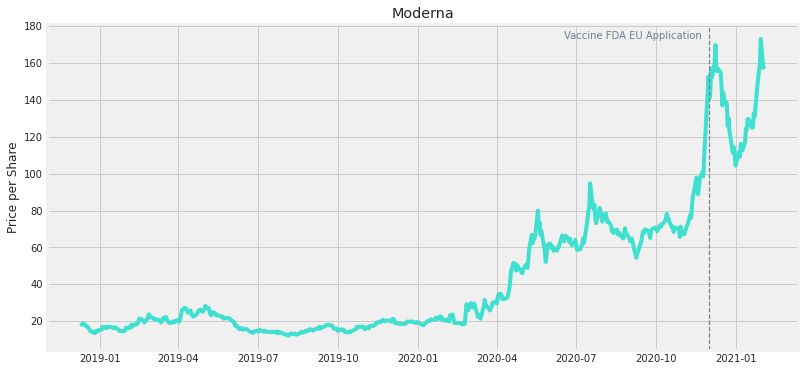

In [32]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(mrna['Adj Close'], color='turquoise')
ax.set(title='Moderna', ylabel='Price per Share') 
ax.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2020-06-17'), max(mrna['Adj Close']), 'Vaccine FDA EU Application', color='slategray')

[Text(0, 0.5, '% Return'), Text(0.5, 1.0, 'Moderna')]

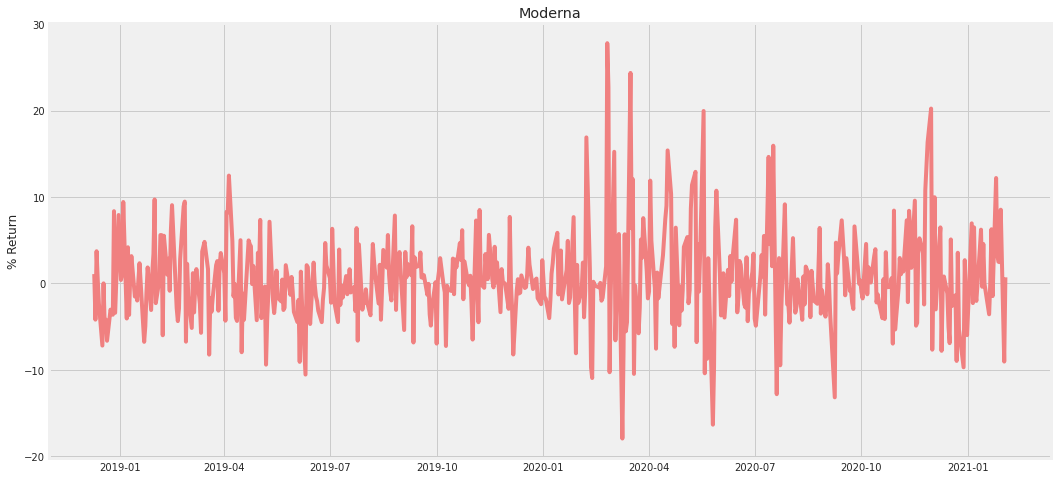

In [4]:
# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mrna['return'], color='lightcoral')
ax.set(title='Moderna', ylabel='% Return') 

MRNA returns show clear signs of clustering.

In [5]:
def volatilities(df):
  daily_volatility = df['return'].std()
  monthly_trade_days = 21; monthly_volatility = np.sqrt(monthly_trade_days) * daily_volatility
  yearly_trade_days = 252; yearly_volatility = np.sqrt(yearly_trade_days) * daily_volatility
  volatility_dict = {'daily':daily_volatility, 'monthly':monthly_volatility, 'yearly':yearly_volatility}
  volatility_df = pd.DataFrame.from_dict(volatility_dict, orient='index', columns=['volatility(%)'])
  return volatility_df

volatilities(mrna)

,volatility(%)
daily,5.256740
monthly,24.089408
yearly,83.448155


### Specify & Fit Model: GJR-GARCH

We learned from our previous post that our optimal model was GJR-GARCH (asymmetric shock) with constant mean and skewed t distribution of standardized residuals. 

In [6]:
gjrgarch_gm = arch_model(mrna['return'], p=1, q=1, o=1, mean='constant', vol='GARCH', dist='skewt') 
gjrgarch_result = gjrgarch_gm.fit(disp='off')
gjrgarch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                         
=========================================================================================
Dep. Variable:                            return   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -1598.55
Distribution:      Standardized Skew Student's t   AIC:                           3211.10
Method:                       Maximum Likelihood   BIC:                           3241.15
                                                   No. Observations:                  541
Date:                           Wed, Feb 03 2021   Df Residuals:                      534
Time:                                   08:14:29   Df Model:                            7
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.4561      0.194      2.354  1.857e-02 [7.636e-02,  0.836]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.4930      2.164      0.690      0.490    [ -2.748,  5.734]
alpha[1]       0.1189      0.141      0.842      0.400    [ -0.158,  0.396]
gamma[1]      -0.1189  4.313e-02     -2.757  5.841e-03 [ -0.203,-3.436e-02]
beta[1]        0.8740      0.200      4.377  1.205e-05    [  0.483,  1.265]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu             6.4472      1.688      3.818  1.343e-04   [  3.138,  9.757]
lambda         0.2059  6.219e-02      3.311  9.307e-04 [8.401e-02,  0.328]
==========================================================================

Covariance estimator: robust
"""

### Standardized Residuals

[Text(0.5, 1.0, 'Standardized Resduals')]

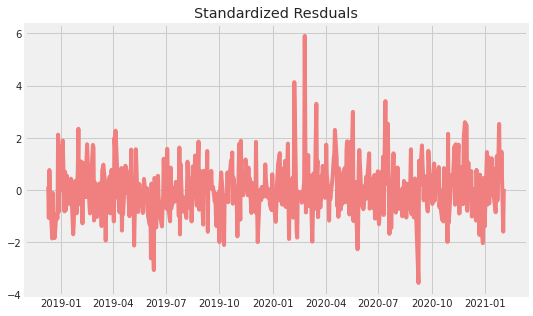

In [62]:
mrna_volatility = gjrgarch_result.conditional_volatility
mrna_volatility.dropna(inplace=True)
mrna_std_resid = gjrgarch_result.resid / mrna_volatility
mrna_std_resid.dropna(inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(mrna_std_resid, color='lightcoral')
ax.set(title='Standardized Resduals') 

## 4. AbbVie

### Collect Data

In [8]:
def abbvie_prices_returns(ticker, start_date, end_date):
  global abbv
  abbv = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)[['Adj Close']]
  abbv['return'] = abbv.pct_change() * 100
  abbv.dropna(inplace=True)
  return abbv

abbvie_prices_returns('ABBV','2018-12-06','2021-02-02')

,Adj Close,return
Date,,
2018-12-07,77.089478,-3.730770
2018-12-10,77.665688,0.747456
2018-12-11,78.162117,0.639188
2018-12-12,78.543327,0.487718
2018-12-13,77.754341,-1.004524
...,...,...
2021-01-27,102.790001,-5.523899
2021-01-28,104.209999,1.381456
2021-01-29,102.480003,-1.660105


Text(2018-12-18 00:00:00, 112.62000274658203, 'Announced Allergan Acquisition')

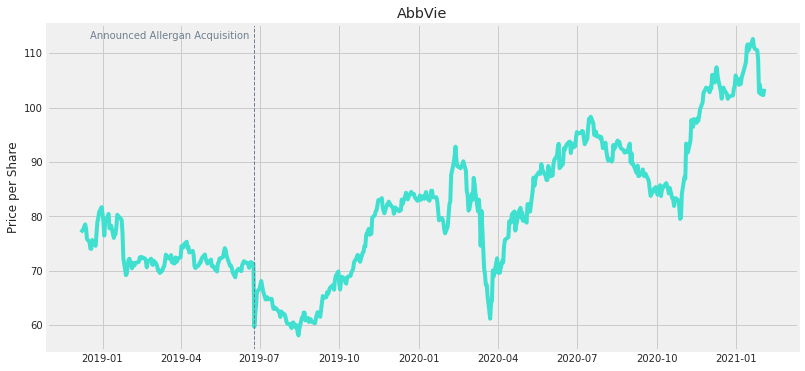

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(abbv['Adj Close'], color='turquoise')
ax.set(title='AbbVie', ylabel='Price per Share') 

ax.axvline(pd.to_datetime('2019-06-25'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2018-12-18'), max(abbv['Adj Close']), 'Announced Allergan Acquisition', color='slategray')

Text(2019-02-04 00:00:00, 8.717440407891065, 'Announced Allergan Acquisition')

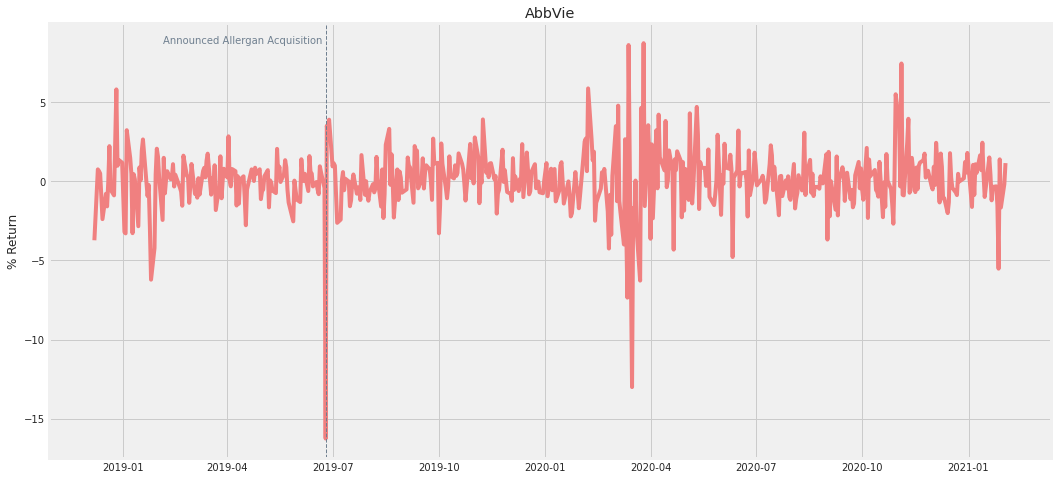

In [43]:
# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(abbv['return'], color='lightcoral')
ax.set(title='AbbVie', ylabel='% Return') 

ax.axvline(pd.to_datetime('2019-06-25'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2019-02-04'), max(abbv['return']), 'Announced Allergan Acquisition', color='slategray')

In [11]:
volatilities(abbv)

,volatility(%)
daily,1.962452
monthly,8.993084
yearly,31.152956


### Specify & Fit GARCH Models

In [12]:
# Constant mean, normal distribution
abbv_basic_gm = arch_model(abbv['return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal') 
abbv_gm_result = abbv_basic_gm.fit(disp='off')

# Constant mean, skew t distribution
abbv_skewt_gm = arch_model(abbv['return'], p=1, q=1, mean='constant', vol='GARCH', dist='skewt') 
abbv_skewt_result = abbv_skewt_gm.fit(disp='off')

# Autoregressive mean, skew t distribution 
abbv_armean_gm = arch_model(abbv['return'], p=1, q=1, mean='AR', lags=1, vol='GARCH', dist='skewt') 
abbv_armean_result = abbv_armean_gm.fit(disp='off')

# EGARCH (asymmetric shock) with constant mean, skew t distribution
abbv_egarch_gm = arch_model(abbv['return'], p=1, q=1, o=1, mean='constant', vol='EGARCH', dist='skewt') 
abbv_egarch_result = abbv_egarch_gm.fit(disp='off')

# GJR-GARCH (asymmetric shock) with constant mean, skew t distribution
abbv_gjrgarch_gm = arch_model(abbv['return'], p=1, q=1, o=1, mean='constant', vol='GARCH', dist='skewt') 
abbv_gjrgarch_result = abbv_gjrgarch_gm.fit(disp='off')

### Goodness of Fit

In [13]:
# Function to create dataframe of log likelihood, AIC, BIC for each model
def goodness_of_fit():
  global df
  model_names = ['normal', 'skewt','AR-skewt', 'EGARCH', 'GJR-GARCH']
  models = [abbv_gm_result, abbv_skewt_result, abbv_armean_result, abbv_egarch_result, abbv_gjrgarch_result]
  likelihood = [model.loglikelihood for model in models]
  aic = [model.aic for model in models]
  bic = [model.bic for model in models]
  dict = {'model':model_names, 'log likelihood':likelihood, 'aic':aic,'bic':bic}
  df = pd.DataFrame(dict).set_index('model')
  return df

goodness_of_fit()

,log likelihood,aic,bic
model,,,
normal,-1092.245945,2192.491890,2209.672954
skewt,-1017.426488,2046.852975,2072.624571
AR-skewt,-1013.387527,2040.775053,2070.828988
EGARCH,-1018.959257,2051.918514,2081.985376
GJR-GARCH,-1017.378826,2048.757652,2078.824514


In [14]:
# Highlight max log likelihood
df.style.highlight_max(subset='log likelihood', color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-1092.245945,2192.491890,2209.672954
skewt,-1017.426488,2046.852975,2072.624571
AR-skewt,-1013.387527,2040.775053,2070.828988
EGARCH,-1018.959257,2051.918514,2081.985376
GJR-GARCH,-1017.378826,2048.757652,2078.824514


In [15]:
# Highlight min AIC, BIC
df.style.highlight_min(subset=['aic', 'bic'], color = 'yellow', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-1092.245945,2192.491890,2209.672954
skewt,-1017.426488,2046.852975,2072.624571
AR-skewt,-1013.387527,2040.775053,2070.828988
EGARCH,-1018.959257,2051.918514,2081.985376
GJR-GARCH,-1017.378826,2048.757652,2078.824514


For AbbVie, GARCH with autoregressive mean and skewed t distribution of standardized residuals performs the best - it has the highest log likelihood and lowest AIC and BIC. 

### Parameter Significance Testing

In [16]:
# Get parameter stats from model summary
parameters = pd.DataFrame({'parameter': abbv_armean_result.params,
                           'p-value': abbv_armean_result.pvalues})

parameters

,parameter,p-value
Const,0.048857,4.599586e-01
return[1],0.003033,9.434119e-01
omega,0.411084,7.187705e-03
alpha[1],0.175463,4.546880e-03
beta[1],0.706597,2.320097e-22
nu,4.275192,1.018274e-05
lambda,-0.026230,6.827241e-01


The high $\alpha$ (alpha usually ranges between 0.05 and 0.1) indicates a large immediate impact on residuals ('jumpy'), while the relatively low $\beta$ (beta usually ranges between 0.80 to 0.98) indicates that the impact doesn't persist long (high alpa, low beta trends typically look more 'spiky'). The significant $\nu$ indicates a t-distribution, though an insignificant $\lambda$ indicates that that there's not much skew. 

To check our parameters, let's run a significance test with alpha of 0.05. We see that some of our parameters actually have a p-value above 0.05. 

Generally, we should be careful with selecting or discarding parameters based on significance testing ([article](https://robjhyndman.com/hyndsight/tests2/)) - it's possible to have an insignificant coefficient for a variable that's useful for forecasting as well as having a significant variable that's better omitted for forecasting. 

We'll also look at standardized residuals to see if our model is capturing as much relevant information as possible and our residuals are truly white noise.

### Standardized Residuals

[Text(0.5, 1.0, 'Standardized Resduals')]

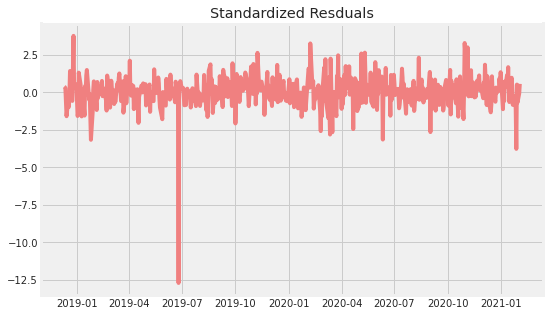

In [63]:
abbv_volatility = abbv_armean_result.conditional_volatility
abbv_volatility.dropna(inplace=True)
abbv_std_resid = abbv_armean_result.resid / abbv_volatility
abbv_std_resid.dropna(inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(abbv_std_resid, color='lightcoral')
ax.set(title='Standardized Resduals') 

Autocorrelation tests randomness in standardized residuals for each lag and any significant autocorrelation in standardized residuals means the model may not be sound.

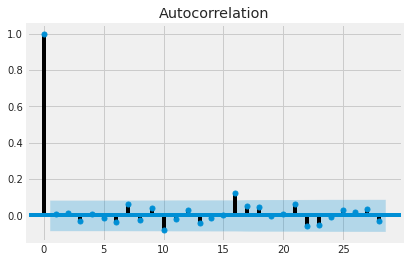

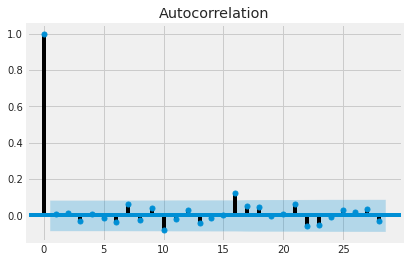

In [18]:
plot_acf(abbv_std_resid, alpha=0.05)

The ACF plot indicates that there does seem to be a significant autocorrelation at 16 lags (residual is not white noise) meaning the model could be improved.

Ljung-Box tests for overall randomness of standardized residuals. The null hypothesis is that the data is independently distributed. P-values <5% means the residuals aren't independently distributed and the model isn't sound. 


In [19]:
# Ljung-Box test
lb_test = acorr_ljungbox(abbv_std_resid, lags=10)

# P-values dataframe, transpose to get lags as columns
p_values = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = p_values.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
p_values.columns = col_names
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
P-values,0.855797,0.930269,0.885179,0.955055,0.976579,0.949206,0.819565,0.856784,0.84733,0.607071


All the p-values are above 5% meaning the null hypothesis can't be rejected and the standardized residuals are independently distributed. 

## 5. Dynamic Covariance

Text(2019-11-05 00:00:00, 8.44470916002513, '1st U.S. Covid lockdown')

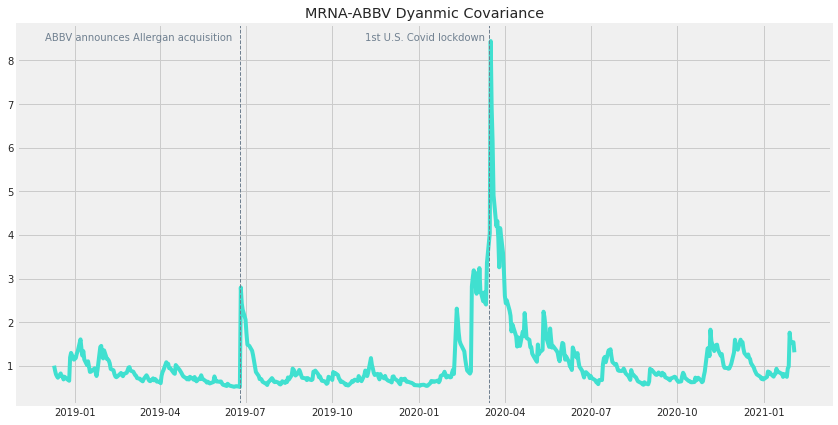

In [65]:
# Calculate dynamic covariance by multiplying correlation by GARCH volatilities
correlation = np.corrcoef(mrna_std_resid, abbv_std_resid)[0,1]
covariance = correlation * mrna_volatility * abbv_volatility
covariance.dropna(inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(13,7))
ax.plot(covariance, color='turquoise')
ax.set(title='MRNA-ABBV Dyanmic Covariance') 
ax.axvline(pd.to_datetime('2019-06-25'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2018-11-30'), max(covariance), 'ABBV announces Allergan acquisition', color='slategray')
ax.axvline(pd.to_datetime('2020-03-15'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2019-11-05'), max(covariance), '1st U.S. Covid lockdown', color='slategray')

## 6. Portfolio Variance

Text(2020-06-01 00:00:00, 88.89145971607739, 'MRNA Covid FDA EUA submission')

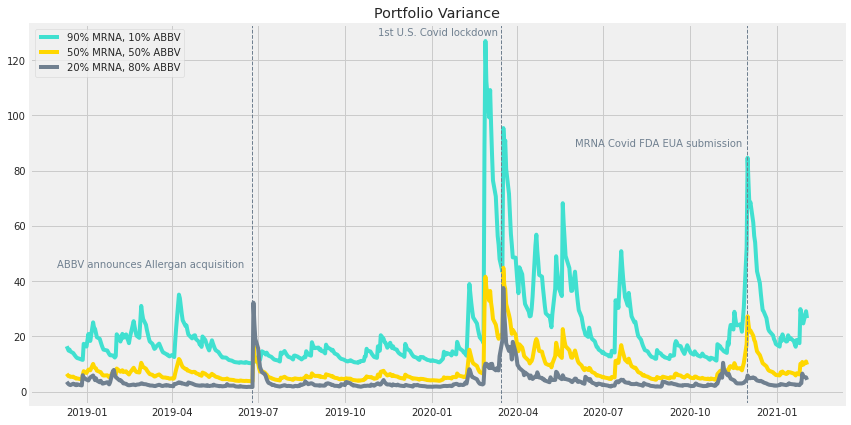

In [96]:
# Variance
mrna_var = mrna_volatility**2 
abbv_var = abbv_volatility**2

# Weights
weight_a_mrna = 0.90
weight_a_abbv = 1 - weight_a_mrna
weight_b_mrna = 0.50
weight_b_abbv = 1 - weight_b_mrna
weight_c_mrna = 0.20
weight_c_abbv = 1 - weight_c_mrna

# Portfolio variance
portfolio_a = (weight_a_mrna**2 * mrna_var) + (weight_a_abbv**2 * abbv_var) + (2*weight_a_mrna*weight_a_abbv*covariance)
portfolio_b = (weight_b_mrna**2 * mrna_var) + (weight_b_abbv**2 * abbv_var) + (2*weight_b_mrna*weight_b_abbv*covariance)
portfolio_c = (weight_c_mrna**2 * mrna_var) + (weight_c_abbv**2 * abbv_var) + (2*weight_c_mrna*weight_c_abbv*covariance)

# Plot
fig, ax = plt.subplots(figsize=(13,7))
ax.plot(portfolio_a, color='turquoise', label='90% MRNA, 10% ABBV')
ax.plot(portfolio_b, color='gold', label='50% MRNA, 50% ABBV')
ax.plot(portfolio_c, color='slategray', label='20% MRNA, 80% ABBV')
ax.set(title='Portfolio Variance') 
ax.legend(loc='upper left')
ax.axvline(pd.to_datetime('2019-06-25'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2018-11-30'), max(portfolio_b), 'ABBV announces Allergan acquisition', color='slategray')
ax.axvline(pd.to_datetime('2020-03-15'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2019-11-05'), max(portfolio_a)+2, '1st U.S. Covid lockdown', color='slategray')
ax.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2020-06-01'), max(portfolio_a)-38, 'MRNA Covid FDA EUA submission', color='slategray')

Portfolio variance decreases as we lower MRNA's weighting. The lowest portfolio variance is portfolio c with 20% MRNA and 80% ABBV. 

## 7. References

https://learn.datacamp.com/skill-tracks/applied-finance-in-python

https://www.modernatx.com/pipeline

https://www.abbvie.com/our-science/products.html

https://www.abbvie.com/our-science/pipeline.html

https://mpra.ub.uni-muenchen.de/73259/1/MPRA_paper_73259.pdf

https://stats.stackexchange.com/questions/192400/interpretation-of-dcc-garch-output

